## Papers analisys

This notebook is an attempt to compute dynamic statistics of the Superconductor datasets papers and extract the distribution of the following information: 
 - Year
 - Source
 - keywords
 - number of pages

 

In [39]:
import json
import os
from pathlib import Path

from bs4 import BeautifulSoup, Tag

In [40]:
def process_dir(input):
    accumulator = []
    abs_start = os.path.abspath(input)
    for root, dirs, files in os.walk(input):
        for file_ in files:
            if file_.lower().endswith(".keyterm.json") or not file_.lower().endswith(".json"):
                continue
            abs_path = os.path.join(root, file_)
#             print("Processing: " + str(abs_path))
            output_data = process_file(abs_path)
            output_data['path'] = os.path.relpath(abs_path, abs_start)
            accumulator.append(output_data)

    return accumulator


def process_file(input):
    with open(input, encoding='utf-8') as fp:
        source_file = json.load(fp)

    year = source_file['date'].split("-")[0] if 'date' in source_file else ''    
    publisher = source_file['publisher'] if 'publisher' in source_file else "N/A"
    source = 'arXiv' if 'arXiv' in source_file else 'N/A'            
    keywords = source_file['keywords'] if 'keywords' in source_file else []
    
    output = {
        "publisher": publisher, 
        "source": source, 
        "year": year,
        "input": input, 
        "keywords": keywords
    }
        
    return output

In [41]:
accumulator = process_dir("/Users/lfoppiano/development/projects/grobid/grobid-superconductors/resources/dataset/superconductors/corpus/biblio")


## Distribution of paper by year

Text(0.5, 1.0, 'Papers by year')

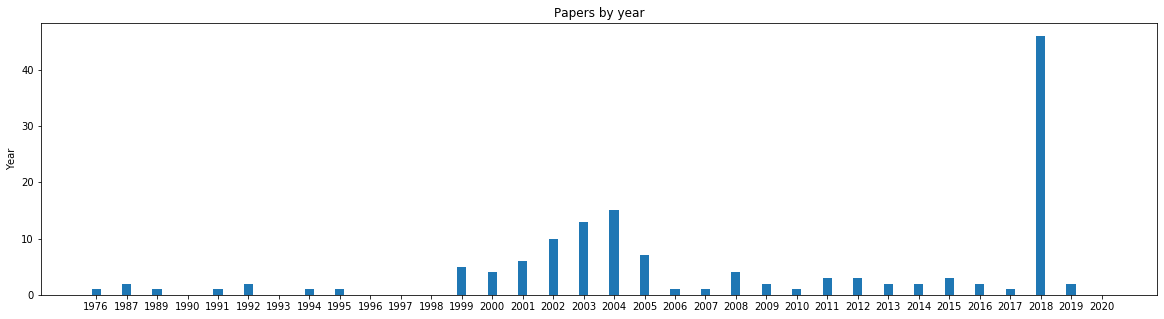

In [42]:
frequency = {}
for paper in accumulator: 
    year = paper['year']
    if year == "": 
        year = "N/A"
#         print(paper)
    if year in frequency: 
        frequency[year] += 1
    else: 
        frequency[year] = 1

for year in range(1990, 2021): 
    if str(year) not in frequency: 
        frequency[str(year)] = 0

    
import collections
frequency_ordered = collections.OrderedDict(sorted(frequency.items()))

        
import matplotlib.pyplot as plt
import numpy as np

x = frequency_ordered.keys()
y = [frequency_ordered[key] for key in frequency_ordered.keys()]

# from matplotlib.pyplot import figure
# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

fig, ax = plt.subplots(figsize=(20, 5)) 

ax.bar(x, y, width=0.3)

ax.set_ylabel('Frequency')
ax.set_ylabel('Year')
ax.set_title('Papers by year')
# ax.legend()


In [43]:
print(x)
print(y)

odict_keys(['1976', '1987', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'])
[1, 2, 1, 0, 1, 2, 0, 1, 1, 0, 0, 0, 5, 4, 6, 10, 13, 15, 7, 1, 1, 4, 2, 1, 3, 3, 2, 2, 3, 2, 1, 46, 2, 0]


## Distribution of papers by source / publisher

Text(0, 0.5, 'Publisher')

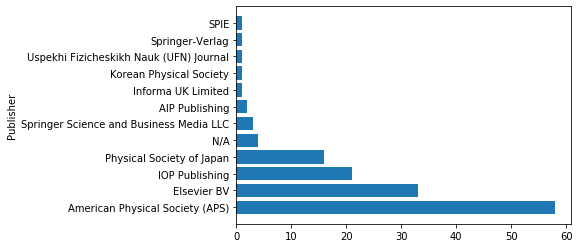

In [29]:
frequency = {}
for paper in accumulator: 
    year = paper['publisher']
    if year == "": 
        year = "N/A"
#         print(paper)
    if year in frequency: 
        frequency[year] += 1
    else: 
        frequency[year] = 1
        

import matplotlib.pyplot as plt
import numpy as np

sorted_by_value = {k: v for k, v in sorted(frequency.items(), key=lambda item: item[1], reverse=True)}

y = list(sorted_by_value.keys())
x = [sorted_by_value[key] for key in sorted_by_value.keys()]

# from matplotlib.pyplot import figure
# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

fig, ax = plt.subplots() 

ax.barh(y,x, align="center")

ax.set_ylabel('Frequency')
ax.set_ylabel('Publisher')
# ax.set_title('Papers by publisher')
# ax.legend()


## Distribution of papers by keywords

Text(0.5, 1.0, 'Papers by Keywords (from the paper header)')

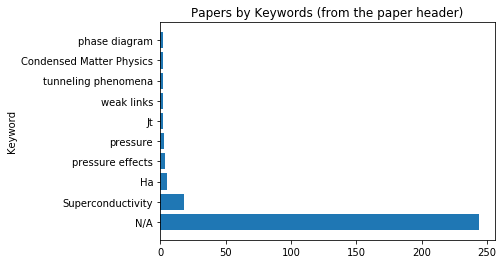

In [30]:
from difflib import SequenceMatcher

def group_by_with_soft_matching(input_list, threshold):
    matching = {}
    last_matching = -1

    for index_x, x in enumerate(input_list):
        unpacked = [y for x in matching for y in matching[x]]
        if x not in matching and x not in unpacked:
            matching[x] = []

            for index_y, y in enumerate(input_list[index_x + 1:]):
                if x == y:
                    continue

                if SequenceMatcher(None, x.lower(), y.lower()).ratio() > threshold:
                    matching[x].append(y)

        else:
            continue

    return matching


import re

frequency = {}
for paper in accumulator: 
    year = paper['keywords']
    if year == []: 
        year = ["N/A"]
#         print(paper)
    for keyword in year:
#         print(keyword)
        keyword = re.sub("^\.", "", keyword)
        keyword = re.sub("^(numbers: )?[0-9]+\.?[0-9]*[A-Za-z.+-]{0,3}", "", keyword)
        keyword = keyword.strip()
        multi_key = keyword.split(",")
        if len(multi_key) > 0: 
            for sub_key in multi_key: 
                if sub_key == "": 
                    sub_key = "N/A"
            
                if sub_key in frequency: 
                    frequency[sub_key] += 1
                else: 
                    frequency[sub_key] = 1
        else: 
            if keyword == "": 
                keyword = "N/A"
            
            if keyword in frequency: 
                frequency[keyword] += 1
            else: 
                frequency[keyword] = 1

group_by = group_by_with_soft_matching(list(frequency.keys()), 0.95)
only_dup = {group_: group_by[group_] for group_ in group_by if len(group_by[group_]) > 0}
            
# print(only_dup)

for key, values in only_dup.items():
#     print(frequency_ordered[key])
    cumulated = frequency[key] 
    for val in values: 
        cumulated += frequency[val]
        del frequency[val]

    frequency[key] = cumulated
#     print(frequency_ordered[key])


sorted_by_value = {k: v for k, v in sorted(frequency.items(), key=lambda item: item[1], reverse=True)}
top_10 = {k:sorted_by_value[k] for k in list(sorted_by_value.keys())[0:10]}




import matplotlib.pyplot as plt
import numpy as np

y = list(top_10.keys())
# y_string = "\n".join(y)
# with open("bao", 'w') as fs: 
#     fs.write(y_string)
    
x = [top_10[key] for key in top_10.keys()]

# from matplotlib.pyplot import figure
# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

fig, ax = plt.subplots() 

ax.barh(y,x, align="center")

ax.set_ylabel('Frequency')
ax.set_ylabel('Keyword')
ax.set_title('Papers by Keywords (from the paper header)')
# ax.legend()

## Distribution by source

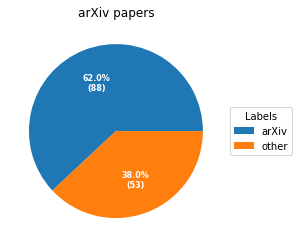

In [31]:
frequency = {}
for paper in accumulator: 
    source = paper['source']
    if source == "" or source == 'N/A': 
        source = "other"
    if source in frequency: 
        frequency[source] += 1
    else: 
        frequency[source] = 1
        
import collections
frequency_ordered = collections.OrderedDict(sorted(frequency.items()))


import matplotlib.pyplot as plt
import numpy as np

x = list(frequency_ordered.keys())
y = [frequency_ordered[key] for key in frequency_ordered.keys()]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)
    

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(y, autopct=lambda pct: func(pct, y),
                                  textprops=dict(color="w"))


ax.legend(wedges, x,
          title="Labels",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")
ax.set_title("arXiv papers")
plt.show()

In [32]:
accumulator[0]

{'publisher': 'American Physical Society (APS)',
 'source': 'arXiv',
 'year': '2003',
 'input': '/Users/lfoppiano/development/projects/grobid/grobid-superconductors/resources/dataset/superconductors/corpus/biblio/batch-1/L091087001-CC.json',
 'keywords': [],
 'path': 'batch-1/L091087001-CC.json'}

# Distribution by keywords (from the body)

In [33]:
def process_dir(input):
    accumulator = []
    abs_start = os.path.abspath(input)
    for root, dirs, files in os.walk(input):
        for file_ in files:
            if file_.lower().endswith(".keyterm.json"):
                abs_path = os.path.join(root, file_)
                keywords = process_file(abs_path)
#                 output_data['path'] = os.path.relpath(abs_path, abs_start)
#                 accumulator.append(output_data)
                accumulator.extend(keywords)

    return accumulator


def process_file(input):
    keywords = []
    with open(input, encoding='utf-8') as fp:
        source_file = json.load(fp)

        keywords = [(keyword['term'], keyword['score']) for keyword in (source_file['categories'] if 'categories' in source_file else [])]

    return keywords

In [34]:
accumulator = process_dir("/Users/lfoppiano/development/projects/grobid/grobid-superconductors/resources/dataset/superconductors/corpus/biblio")

Text(0.5, 1.0, 'Top 10 keywords distribution')

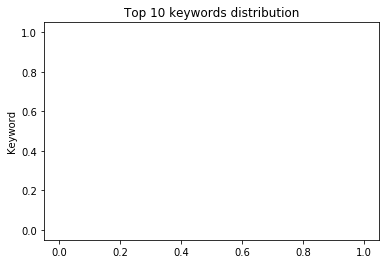

In [35]:
frequency = {}
for keyword in accumulator: 
    if keyword[0] in frequency: 
        frequency[keyword[0]] += 1
    else: 
        frequency[keyword[0]] = 1

sorted_by_value = {k: v for k, v in sorted(frequency.items(), key=lambda item: item[1], reverse=True)}
top_10 = {k:sorted_by_value[k] for k in list(sorted_by_value.keys())[0:20]}
# import collections
# frequency_ordered = collections.OrderedDict(sorted(frequency.items()))

import matplotlib.pyplot as plt
import numpy as np

y = list(top_10.keys())
# y_string = "\n".join(y)
# with open("bao", 'w') as fs: 
#     fs.write(y_string)
    
x = [top_10[key] for key in top_10.keys()]

# from matplotlib.pyplot import figure
# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

fig, ax = plt.subplots() 

ax.barh(y,x, align="center")

ax.set_ylabel('Frequency')
ax.set_ylabel('Keyword')
ax.set_title('Top 10 keywords distribution')

Text(0.5, 1.0, 'Top 10 keywords distribution')

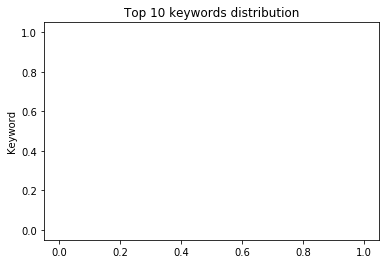

In [36]:
frequency = {}
for keyword in accumulator: 
    if keyword[0] in frequency: 
        frequency[keyword[0]] += round(float(keyword[1]), 2)
    else: 
        frequency[keyword[0]] = round(float(keyword[1]), 2)

sorted_by_value = {k: v for k, v in sorted(frequency.items(), key=lambda item: item[1], reverse=True)}
top_10 = {k:sorted_by_value[k] for k in list(sorted_by_value.keys())[0:10]}
# import collections
# frequency_ordered = collections.OrderedDict(sorted(frequency.items()))

import matplotlib.pyplot as plt
import numpy as np

y = list(top_10.keys())
# y_string = "\n".join(y)
# with open("bao", 'w') as fs: 
#     fs.write(y_string)
    
x = [top_10[key] for key in top_10.keys()]

# from matplotlib.pyplot import figure
# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

fig, ax = plt.subplots() 

ax.barh(y,x, align="center")

ax.set_ylabel('Frequency')
ax.set_ylabel('Keyword')
ax.set_title('Top 10 keywords distribution')